In this project we want to see if we can use time series data to predict stock prices using the linear regression machine learning model. 

In [ ]:
Read the data into a csv, we'll read the Date in as a datetime64 using the parse_dates function.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot


aapl_data = pd.read_csv('./data/AAPL.csv', parse_dates=[0] )
amrs_data = pd.read_csv('./data/AMRS.csv', parse_dates=[0] )

First we'll scan the data with .info and .head()

In [2]:
aapl_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-12-21,11.535714,11.585357,11.501786,11.578571,9.927061,256354000
1,2010-12-22,11.584286,11.632857,11.555357,11.612857,9.956459,265921600
2,2010-12-23,11.607143,11.612500,11.541786,11.557143,9.908693,223157200
3,2010-12-27,11.530357,11.622857,11.482857,11.595714,9.941760,249816000
4,2010-12-28,11.639643,11.666429,11.609286,11.623929,9.965950,175924000


In [3]:
aapl_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2769.0,4.526155e+01,3.770722e+01,1.131000e+01,2.041429e+01,2.963750e+01,5.078000e+01,1.811200e+02
High,2769.0,4.573402e+01,3.816040e+01,1.134643e+01,2.054071e+01,2.985750e+01,5.118000e+01,1.821300e+02
Low,2769.0,4.479763e+01,3.727204e+01,1.108929e+01,2.022893e+01,2.943750e+01,5.039000e+01,1.755300e+02
Close,2769.0,4.528484e+01,3.773908e+01,1.126143e+01,2.041071e+01,2.973250e+01,5.078250e+01,1.794500e+02
Adj Close,2769.0,4.351186e+01,3.832338e+01,9.655157e+00,1.769019e+01,2.746896e+01,4.962371e+01,1.794500e+02
Volume,2769.0,2.407074e+08,1.968075e+08,4.100000e+07,1.064216e+08,1.674600e+08,3.132500e+08,1.880998e+09


Since we want to predict the stock price, we'll use the close value as the prediction target.

In [4]:
aapl_data = aapl_data.sort_index(ascending=True, axis=0)
new_aapl_df = pd.DataFrame(index=range(0,len(aapl_data)),columns=['Date', 'Close'])

for i in range(0,len(aapl_data)):
     new_aapl_df['Date'][i] = aapl_data['Date'][i]
     new_aapl_df['Close'][i] = aapl_data['Close'][i]


In [5]:
new_aapl_df['Date'] = pd.to_datetime(new_aapl_df['Date'])

Some feature engineering to predict the trend in stock prices

In [6]:
new_aapl_df['year'] = new_aapl_df['Date'].dt.year
new_aapl_df['month'] = new_aapl_df['Date'].dt.month
new_aapl_df['week'] = new_aapl_df['Date'].dt.week
new_aapl_df['day'] = new_aapl_df['Date'].dt.day
new_aapl_df['dayofweek'] = new_aapl_df['Date'].dt.dayofweek

<ipython-input-6-44e6ac75c9f9>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  new_aapl_df['week'] = new_aapl_df['Date'].dt.week


In [7]:
new_aapl_df['mon_fri'] = 0
for i in range(0,len(new_aapl_df)):
    if (new_aapl_df['dayofweek'][i] == 0 or new_aapl_df['dayofweek'][i] == 4):
        new_aapl_df['mon_fri'][i] = 1
    else:
        new_aapl_df['mon_fri'][i] = 0

<ipython-input-7-5f3afb6d88e1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_aapl_df['mon_fri'][i] = 0
<ipython-input-7-5f3afb6d88e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_aapl_df['mon_fri'][i] = 1


In [8]:
new_aapl_df

,Date,Close,year,month,week,day,dayofweek,mon_fri
0,2010-12-21,11.578571,2010,12,51,21,1,0
1,2010-12-22,11.612857,2010,12,51,22,2,0
2,2010-12-23,11.557143,2010,12,51,23,3,0
3,2010-12-27,11.595714,2010,12,52,27,0,1
4,2010-12-28,11.623929,2010,12,52,28,1,0
...,...,...,...,...,...,...,...,...
2764,2021-12-14,174.330002,2021,12,50,14,1,0
2765,2021-12-15,179.300003,2021,12,50,15,2,0
2766,2021-12-16,172.259995,2021,12,50,16,3,0
2767,2021-12-17,171.139999,2021,12,50,17,4,1


In [9]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

train = new_aapl_df[:1939]
test = new_aapl_df[1939:]

X_train = train.drop(['Close','Date'],axis=1)
y_train = train['Close']

X_test = test.drop(['Close','Date'],axis=1)
y_test = test['Close']

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test) 


RMSE = mean_squared_error(y_test, y_pred, squared=False)

print(RMSE)

55.62889730173937


In [10]:
test['Predictions'] = y_pred

<ipython-input-10-b47df330c641>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = y_pred


In [11]:
test

,Date,Close,year,month,week,day,dayofweek,mon_fri,Predictions
1939,2018-09-05,56.717499,2018,9,36,5,2,0,41.484013
1940,2018-09-06,55.775002,2018,9,36,6,3,0,41.488454
1941,2018-09-07,55.325001,2018,9,36,7,4,1,41.475807
1942,2018-09-10,54.5825,2018,9,37,10,0,1,41.572007
1943,2018-09-11,55.962502,2018,9,37,11,1,0,41.593537
...,...,...,...,...,...,...,...,...,...
2764,2021-12-14,174.330002,2021,12,50,14,1,0,54.936141
2765,2021-12-15,179.300003,2021,12,50,15,2,0,54.940582
2766,2021-12-16,172.259995,2021,12,50,16,3,0,54.945024
2767,2021-12-17,171.139999,2021,12,50,17,4,1,54.932377


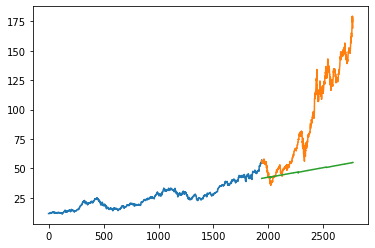

In [12]:
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])

In this case the linear regression model wasn't very good at predicting the spike in aapl's stock price. I think we need to use a different model to better predict to change in prices.

Came across the autoregressive ARIMA Model, to see if this time series data is suitable for a autoregressive model, 
we need to see if there is linear shape to the lag plot. We use a lag plot instead of a regular plot so that outliers
are are more distinct and to check for the randomness of the data.

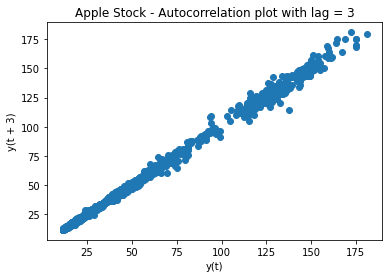

In [13]:
plt.figure()
lag_plot(aapl_data['Open'], lag=3)
plt.title('Apple Stock - Autocorrelation plot with lag = 3')
plt.show()

In [14]:
In this case there is a linear shape so we can try applying the ARIMA Model

SyntaxError: invalid syntax (<ipython-input-14-713e15ca354e>, line 1)

Implementing autoregressive ARIMA Model

In [15]:
!pip install pmdarima

In [16]:
from pmdarima import auto_arima

train = new_aapl_df[:1939]
test = new_aapl_df[1939:]

training = train['Close']
validation = test['Close']

model = auto_arima(training, trace=True)
model.fit(training)

forecast = model.predict(n_periods=830)
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1922.220, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1931.876, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1928.292, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1928.072, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1936.615, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1931.489, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1931.393, Time=0.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1924.183, Time=1.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.856, Time=1.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1929.788, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1931.612, Time=0.89 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1932.135, Time=0.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1926.218, Time=1.54 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1926.503, Time=0.65 sec

Best model:  ARIMA(2,1,2)(0,0,0)

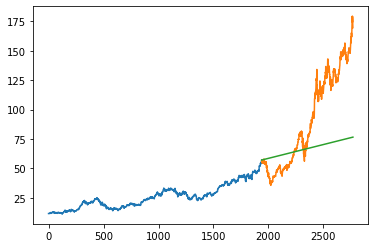

In [17]:
plt.plot(train['Close'])
plt.plot(test['Close'])
plt.plot(forecast['Prediction'])

In [18]:
amrs_data = amrs_data.sort_index(ascending=True, axis=0)
new_amrs_data = pd.DataFrame(index=range(0,len(aapl_data)),columns=['Date', 'Close'])

for i in range(0,len(amrs_data)):
     new_amrs_data['Date'][i] = amrs_data['Date'][i]
     new_amrs_data['Close'][i] = amrs_data['Close'][i]

In [19]:
new_amrs_data['Date'] = pd.to_datetime(new_amrs_data['Date'])

In [20]:
new_amrs_data['year'] = new_amrs_data['Date'].dt.year
new_amrs_data['month'] = new_amrs_data['Date'].dt.month
new_amrs_data['week'] = new_amrs_data['Date'].dt.week
new_amrs_data['day'] = new_amrs_data['Date'].dt.day
new_amrs_data['dayofweek'] = new_amrs_data['Date'].dt.dayofweek

<ipython-input-20-ac2ad8284f77>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  new_amrs_data['week'] = new_amrs_data['Date'].dt.week


In [21]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

train = new_amrs_data[:1939]
test = new_amrs_data[1939:]

X_train = train.drop(['Close','Date'],axis=1)
y_train = train['Close']

X_test = test.drop(['Close','Date'],axis=1)
y_test = test['Close']

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test) 


RMSE = mean_squared_error(y_test, y_pred, squared=False)

print(RMSE)

142.08208254291918


In [22]:
test['Predictions'] = y_pred

<ipython-input-22-b47df330c641>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = y_pred


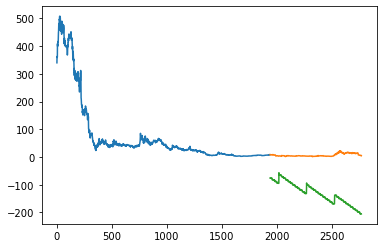

In [23]:
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])